In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/AI/AILecture/Final'

In [ ]:
###########################################################
###prof.sample
# handsign.py
# Code written by prof. Won-Du Chang @PKNU, Rep. Korea
# All rights are reserved to the Author. (chang@pknu.ac.kr)

import numpy as np
import os
#각 데이터의 길이를 체크하고 최대길이 확인
def getMaxLen(folderpath_train, folderpath_test):
    nMaxLen = 0
    for filename in os.listdir(folderpath_train):
        filepath = f'{folderpath_train}/{filename}'
        d, tmp = load_aSig(filepath)
        if d.shape[0] > nMaxLen:
            nMaxLen = d.shape[0]

    for filename in os.listdir(folderpath_test):
        filepath = f'{folderpath_test}/{filename}'
        d, tmp = load_aSig(filepath)
        if d.shape[0] > nMaxLen:
            nMaxLen = d.shape[0]

    return nMaxLen

#학습용 데이터 load
def load_aSig(filepath):
    f = open(filepath,'rt')
    nPoints = int(f.readline())
    d = np.zeros((nPoints,2))
    for i in range(nPoints):
        line = f.readline()
        toks = line.split(' ')
        d[i,:] = [int(toks[0]), int(toks[1])]
    f.close()
    return d, nPoints

#테스트용 데이터 load
def load_data(folderpath,nMaxLen, sig_ids):
    filelist = os.listdir(folderpath)
    nFiles = len(filelist)
    d = np.zeros((nFiles,nMaxLen,2))
    len_sign = np.zeros(nFiles)

    for i in sig_ids:
        filepath = f'{folderpath}/{i}.TXT'
        d_tmp, len_sign[i-sig_ids[0]] = load_aSig(filepath)
        d[i-sig_ids[0],:d_tmp.shape[0],:] = d_tmp
    return d, len_sign


In [ ]:
###########################################################
###prof.sample
# student_sample.py
# Code written by prof. Won-Du Chang @PKNU, Rep. Korea
# All rights are reserved to the Author. (chang@pknu.ac.kr)
#import handsign as sign
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, Activation, Dense
from tensorflow.keras.layers import Flatten, Convolution2D, MaxPooling2D
#데이터 폴더 지정
folderpath_train = './Train'   #학습용 데이터
folderpath_test = './Test'     #테스트용 데이터
filepath_train_info = './info/train_info.csv'   #정답 데이터

#데이터 읽어오기
nMaxLen = getMaxLen(folderpath_train, folderpath_test) #각 데이터의 길이를 체크하고 최대길이 확인
x_train, x_train_len = load_data(folderpath_train,nMaxLen, range(800))     #학습용 데이터 load
x_test, x_test_len  = load_data(folderpath_test,nMaxLen, range(800,1600))  #테스트용 데이터 load

#학습용 데이터 변환
y_train_pd = pd.read_csv(filepath_train_info)
y_train = np.array(y_train_pd['bGenuine'])
y_train_cat = keras.utils.to_categorical(y_train)


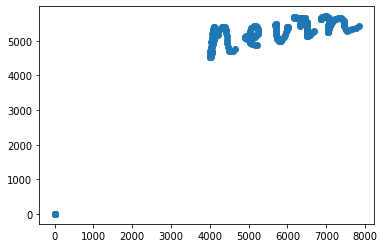

In [ ]:
#signature 보기
import matplotlib.pyplot as plt
plt.scatter(x_train[100, :, 0],x_train[100, :, 1])
#x_train[0, :, 0] : [0번째 사인, 모든 점, x 좌표]
#x_train[0, :, 1] : [0번째 사인, 모든 점, y 좌표]

In [ ]:
#x_train = x_train.reshape(800, 40, 40, -1)
x_train = np.expand_dims(x_train, -1)
x_train.shape

(800, 793, 2, 1)

In [ ]:
import os, re, glob
model = Sequential()
model.add(Convolution2D(16, 3, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
  
model.add(Convolution2D(64, 3, 3,  activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
 
model.add(Convolution2D(64, 3, 3))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Dropout(0.25))
  
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation = 'softmax'))
  
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.fit(x_train, y_train_cat, batch_size=32, nb_epoch=100)

model.save('flowers.h5')

In [ ]:
# x_train = np.append(x_train, x_test, axis=0)
# y_train_cat = np.append(y_train_cat, Y_test, axis=0)

# Save Model with CheckPoint & StopPoint
from keras.callbacks import ModelCheckpoint,EarlyStopping
import os
import datetime
 
Datetime = datetime.datetime.now().strftime('%m%d_%H%M')
modelpath="signature.h5"
 
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='loss', patience=50)
 
# Learning and save models
model.fit(x_train, y_train_cat, validation_split=0.1, epochs=3500, batch_size=10, verbose=0, callbacks=[early_stopping_callback,checkpointer])

In [ ]:
model.summary()

In [ ]:
#loss값 확인
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='test loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')
plt.show()

In [ ]:
#accuracy값 확인
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
loss_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
loss_ax.plot(hist.history['val_accuracy'], 'r', label='test accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper right')
plt.show()

In [ ]:
#제출용 파일 작성
o = model.predict(x_test)
o[:,0] = range(800,1600)
o_df = pd.DataFrame(o,columns=['id','predicted'])
o_df['id'] = o_df['id'].astype(int)
o_df.to_csv('./result/output28.csv',index=None)